<a href="https://colab.research.google.com/github/ahmadhajmosa/Machine-Learning-Lab-2020/blob/Taraneh/OneshotMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##One Shot Learning Siamese network with MNIST data

Reference: [Siamese Neural Networks for One-shot Image Recognition paper from Gregory Koch et all](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)

## **SIAMESE Network**
The model learns image representation via a supervised metric-based approch with Siamese neural network, then reuse that networks features for one shot learning without any retraining.
# General strategy:
1. train a model to discriminate between a collection of same/ different pairs
2. generalize to evaluate new categories base on learned feature mappings for verification.


# Importing Dependencies

In [ ]:
#import libraries
import numpy as np 
import matplotlib.pyplot as plt 
import random
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Lambda, Input, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam 
import tensorflow.keras.backend as K


# Seeding Random number generators

In [ ]:
#fix randoms
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

# Load Data

In [ ]:
#Load the data
def load_data():
    mnist_data = tf.keras.datasets.mnist.load_data()
    return mnist_data

# Prepare Data

In [ ]:
#Prepare the data
def data_preprocessing(mnist_data):
    (X_train, y_train), (X_test, y_test) = mnist_data
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
    # Reserve 10,000 samples for validation
    X_val = X_train[-10000:]
    y_val = y_train[-10000:]
    X_train = X_train[:-10000]
    y_train = y_train[:-10000]
    return (X_train, y_train), (X_test, y_test), (X_val,y_val )

In [ ]:
mnist_data = load_data()
(X_train, y_train), (X_test, y_test), (X_val,y_val ) = data_preprocessing(mnist_data)
print("X_train Shape: {}".format(X_train.shape))
print("y_train Shape: {}".format(y_train.shape))
print("X_test Shape: {}".format(X_test.shape))
print("y_test Shape: {}".format(y_test.shape))
print("X_val Shape: {}".format(X_val.shape))
print("y_val Shape: {}".format(y_val.shape))

11493376/11490434 [==============================] - 0s 0us/step
X_train Shape: (50000, 28, 28)
y_train Shape: (50000,)
X_test Shape: (10000, 28, 28)
y_test Shape: (10000,)
X_val Shape: (10000, 28, 28)
y_val Shape: (10000,)


# Plot the data

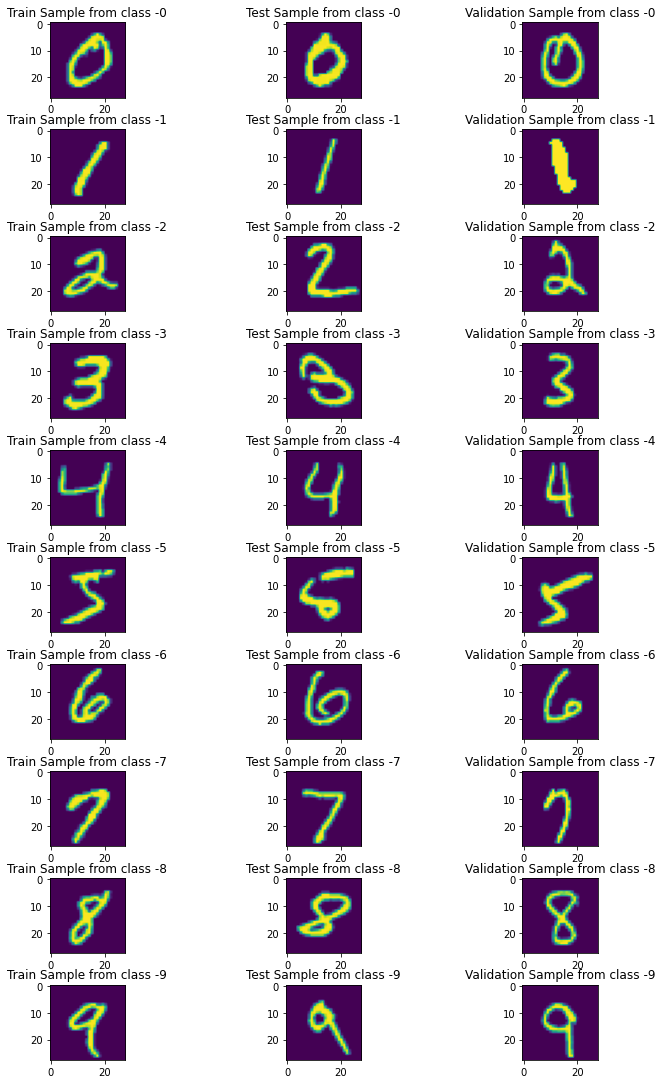

In [ ]:
#Plot the data
f, ax = plt.subplots(10,3, figsize = (10,15))
f.tight_layout()
for j in range(10):
    k = 0
    while(True):
        if y_train[k] == j: #from train samples choose the k that gives the label equal to j from 0 to 10 
            ax[j,0].imshow(X_train[k])
            ax[j,0].set_title("Train Sample from class -"+str(j))
            break
        k+=1
    
    k = 0
    while(True):
        if y_test[k] == j: #from test samples choose the k that gives the label equal to j from 0 to 10 
            ax[j,1].imshow(X_test[k])
            ax[j,1].set_title("Test Sample from class -"+str(j))
            break
        k+=1
    
    k = 0
    while(True):
        if y_val[k] == j: #from validation samples choose the k that gives the label equal to j from 0 to 10 
            ax[j,2].imshow(X_val[k])
            ax[j,2].set_title("Validation Sample from class -"+str(j))
            break
        k+=1

#Prepare pairs

In [ ]:
#Prepare same and different pairs
def make_pairs(images, labels):

    X, y = [],[]
    num_classes = 10
    label_to_idx = [np.where(labels==i)[0] for i in range(num_classes)] #creates a list of 10 elements each element contains the indexes of that element in y (like elemnt 0 contains all the indexes of zero in the y/labels)

    for i in tqdm(range(len(images))):
        
        #same image type - 0
        lbl1 = labels[i] #give the ith label to lbl1
        id = random.choice(label_to_idx[lbl1])# find the index of a random id of lbl1 label/type
        X.append([images[i], images[id]]) #append the 2 same type/label images
        y.append([0])

        #different image type - 1
        lbl2 = random.randint(0, len(label_to_idx)-1) #create a random number between 0 and 9
        while(lbl2 == lbl1):
            lbl2 = random.randint(0, len(label_to_idx)-1) #create lbl2 different from lbl1
        #print(lbl2)
        id = random.choice(label_to_idx[lbl2])# find the index of a random sample of the lbl2 type
        X.append([images[i], images[id]]) #append 2 different type/label images
        y.append([1])
    
    X, y = np.array(X), np.array(y)
    return X,y

In [ ]:
# Test and train pairs
X_train_pair, y_train_pair = make_pairs(X_train, y_train)
X_test_pair, y_test_pair = make_pairs(X_test, y_test)
X_val_pair, y_val_pair = make_pairs(X_val, y_val)

print("X_train Shape: {}".format(X_train_pair.shape))
print("y_train Shape: {}".format(y_train_pair.shape))
print("X_test Shape: {}".format(X_test_pair.shape))
print("y_test Shape: {}".format(y_test_pair.shape))
print("X_val Shape: {}".format(X_val_pair.shape))
print("y_val Shape: {}".format(y_val_pair.shape))

100%|██████████| 10000/10000 [00:00<00:00, 114506.18it/s]


X_train Shape: (100000, 2, 28, 28)
y_train Shape: (100000, 1)
X_test Shape: (20000, 2, 28, 28)
y_test Shape: (20000, 1)
X_val Shape: (20000, 2, 28, 28)
y_val Shape: (20000, 1)


# Dispaly Pairs for different sets

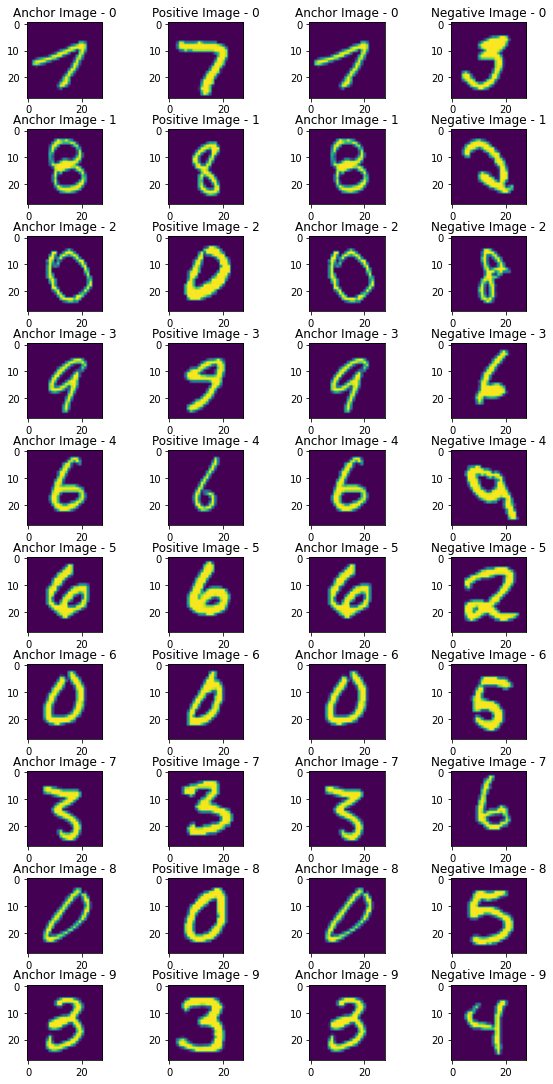

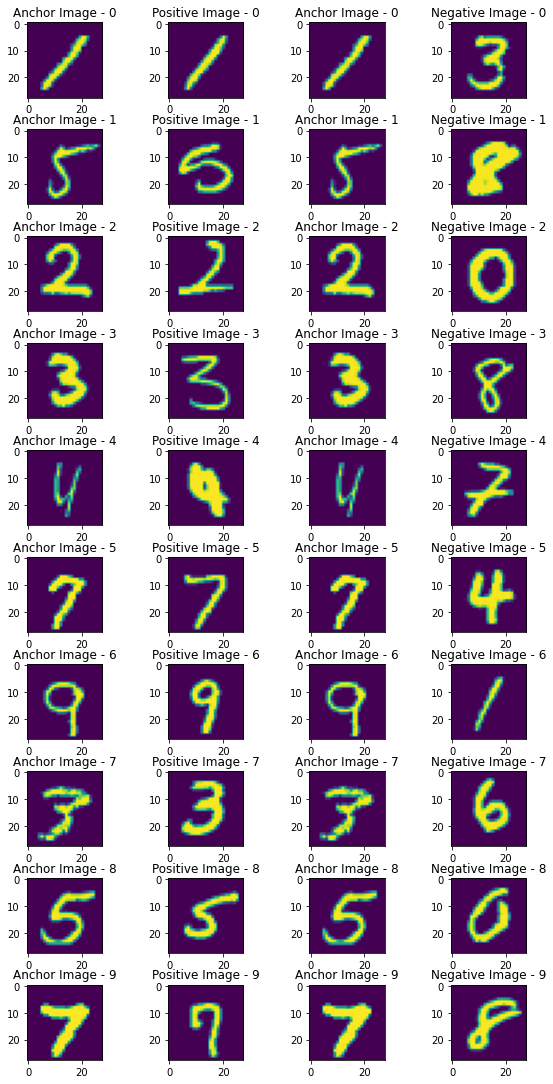

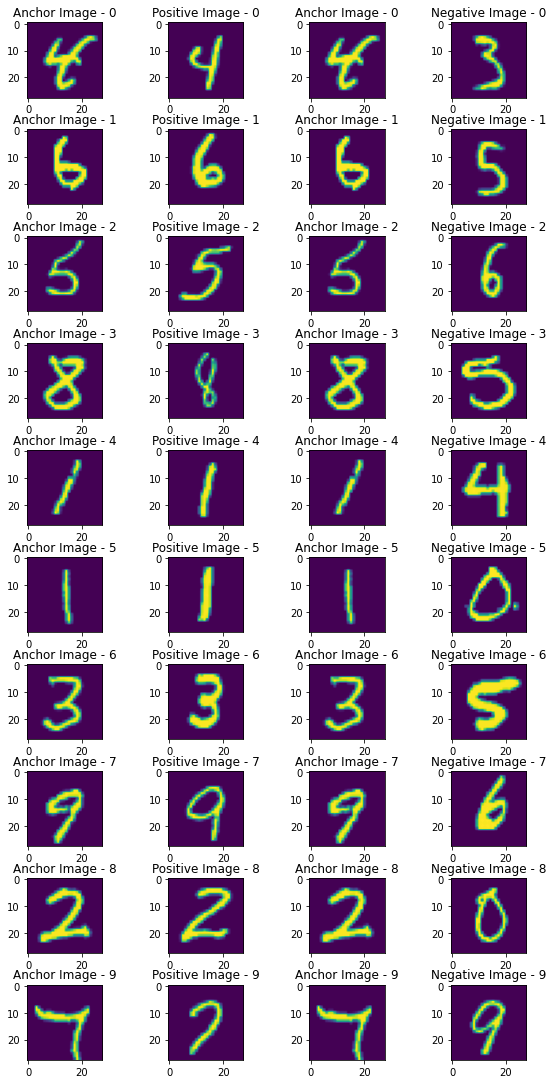

In [ ]:
#Display 10 pairs of each set
def display_data_pairs(X,y):
    f, ax = plt.subplots(10,4, figsize = (8,15))
    f.tight_layout()

    j=0
    while(True):
        if j==10:
            break
        k = random.randint(0,len(X)) #take a random number between zero and lenght of X
        if y[k] == 0: #make sure they are same images
            ax[j,0].imshow(X[k][0])
            ax[j,0].set_title("Anchor Image - "+str(j))
            ax[j,1].imshow(X[k][1])
            ax[j,1].set_title("Positive Image - "+str(j))
            
            k+=1 #next image is different images
            ax[j,2].imshow(X[k][0])
            ax[j,2].set_title("Anchor Image - "+str(j))
            ax[j,3].imshow(X[k][1])
            ax[j,3].set_title("Negative Image - "+str(j))
            j+=1
        
display_data_pairs(X_train_pair, y_train_pair)
display_data_pairs(X_test_pair, y_test_pair)
display_data_pairs(X_val_pair, y_val_pair)

In [ ]:
#Plot for the result
def plot_metric(history):
    acc, val_acc, loss, val_loss = history['accuracy'], history['val_accuracy'], history['loss'], history['val_loss']
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.plot(acc, label = 'Training Accuracy')
    plt.plot(val_acc, label = 'Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc = "upper left")

    plt.subplot(1,2,2)
    plt.plot(loss, label = 'Training Loss')
    plt.plot(val_loss, label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc = "upper left")

In [ ]:
#Euclidean distance
def euclidean_dist(vect):
    x, y = vect
    sum_square = K.sum(K.square(x-y), axis = 1, keepdims = True)
    result = K.maximum(sum_square, K.epsilon())# K.epsilon() = 1e-07
    return result

# Siamese Network Architecture¶
![](https://drive.google.com/uc?export=view&id=1HKAjScVq6m3EOswe2IaDclc1VOHrxk0D)

In [ ]:
#Siamese model
def get_model():
    input = Input((28,28))
    x = Flatten()(input)
    x = Dense(128, activation ='relu')(x)
    dense = Model(input, x)

    input1 = Input((28,28))
    input2 = Input((28,28))

    dense1 = dense(input1)
    dense2 = dense(input2)

    merge_layer = Lambda(euclidean_dist)([dense1, dense2])
    dense_layer = Dense(1, activation = 'sigmoid')(merge_layer)
    model =  Model(inputs = [input1, input2], outputs = dense_layer)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [ ]:
model = get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 128)          100480      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [ ]:
model.count_params()

100482

In [ ]:
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
mc = ModelCheckpoint(
    filepath, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')

tb = TensorBoard(
    log_dir = "logs",
    histogram_freq = 1,
    write_graph = True,
    write_images = True,
    profile_batch = 2,
)
callbacks_list = [mc, tb]

Epoch 1/8
4997/5000 [============================>.] - ETA: 0s - loss: 0.3719 - accuracy: 0.8521
Epoch 00001: val_accuracy improved from -inf to 0.90035, saving model to weights-improvement-01-0.90.hdf5
5000/5000 [==============================] - 22s 4ms/step - loss: 0.3719 - accuracy: 0.8521 - val_loss: 0.2735 - val_accuracy: 0.9003
Epoch 2/8
4995/5000 [============================>.] - ETA: 0s - loss: 0.2472 - accuracy: 0.9072
Epoch 00002: val_accuracy improved from 0.90035 to 0.90555, saving model to weights-improvement-02-0.91.hdf5
5000/5000 [==============================] - 22s 4ms/step - loss: 0.2472 - accuracy: 0.9072 - val_loss: 0.2401 - val_accuracy: 0.9056
Epoch 3/8
4989/5000 [============================>.] - ETA: 0s - loss: 0.2236 - accuracy: 0.9163
Epoch 00003: val_accuracy improved from 0.90555 to 0.90980, saving model to weights-improvement-03-0.91.hdf5
5000/5000 [==============================] - 22s 4ms/step - loss: 0.2238 - accuracy: 0.9162 - val_loss: 0.2289 - val_

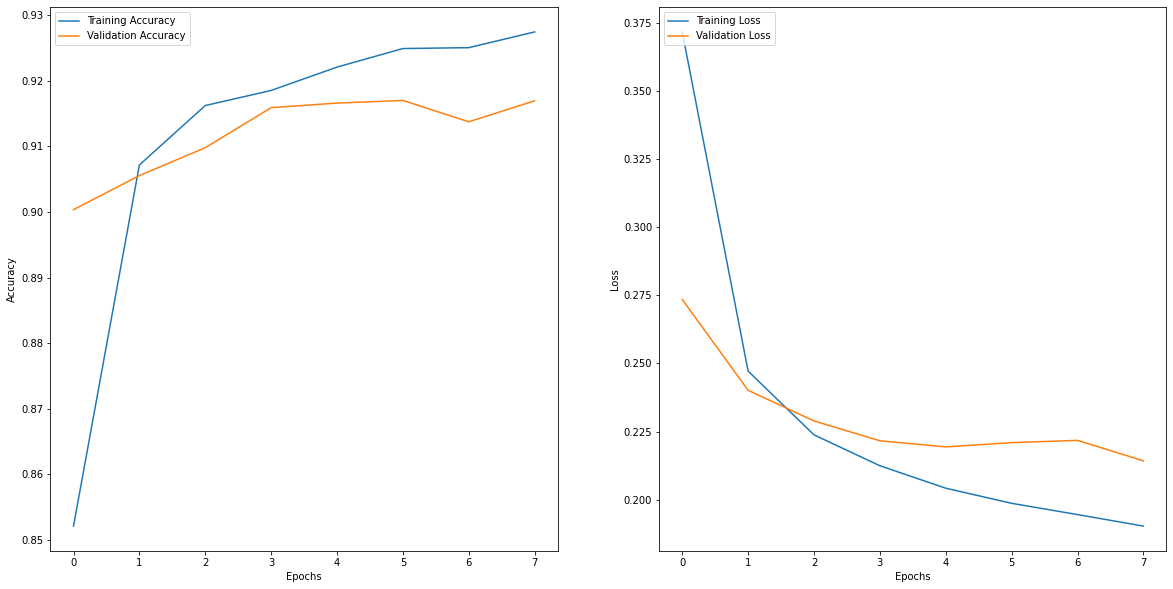

In [ ]:
#Fit the model and plot the result
history = model.fit([X_train_pair[:,0], X_train_pair[:,1]], y_train_pair, batch_size = 16, epochs = 8,verbose=1, shuffle= True, validation_split = 0.2, callbacks=callbacks_list)
plot_metric(history.history)

In [ ]:
results = model.evaluate([X_val_pair[:,0],X_val_pair[:,1]], y_val_pair, batch_size=16)
print("Test Data Accuracy: {:.2f}%".format(results[1]*100))
print("Test Data loss:     {:.2f}".format(results[0]))  

1250/1250 [==============================] - 3s 3ms/step - loss: 0.2113 - accuracy: 0.9206
Test Data Accuracy: 92.06%
Test Data loss:     0.21


# N way One shot Testing
In order to evaluate this model, we will perform N-way one shot classification. Here N implies how many images will be there in the support set .

Say, there is 1 image for evaluation, N images of different class in support set, and exactly one image is from the same class as the test image for evaluation.

Model should predict high probability for the pair of images which belong to same class and low probability to remaining N-1 pairs.

Note : To test N-way one shot , instead of testing all possible pairs for each N [2, 5, 6, 9] sampled support set for all classes randomly.

In [ ]:
def test_one_shot(model,X_left,X_right):
    prob = model.predict([X_left,X_right])
    if np.argmin(prob) == 0:
        return 1
    else:
        return 0

In [ ]:
def load_test_batch(n_samples):
    correct_pred = 0
    labels = np.unique(y_test)
    label_to_idx = [np.where(y_test==label)[0] for label in labels]

    for i in tqdm(range(len(labels))):
        X_left, X_right =[],[]

        #same image type 
        lbl1 = i 
        label_ids = label_to_idx[lbl1]
        id1 = random.choice(label_ids)
        id2 = random.choice(label_ids)
        img0 = X_test[id1]
        img1 = X_test[id2]
        X_left.append(img0)
        X_right.append(img1)
        

        #different image type 
        for _ in range(n_samples):
            lbl2 = random.randint(0, len(labels)-1) #create a random number between 0 and 9
            while(lbl2 == lbl1):
                lbl2 = random.randint(0, len(labels)-1) #create lbl2 different from lbl1 
            id3 = random.choice(label_to_idx[lbl2])# find the index of a random sample of the lbl2 type
            img2 = X_test[id3]
            X_left.append(img0)
            X_right.append(img2)
            

        X_left, X_right = np.array(X_left), np.array(X_right)
        correct_pred += test_one_shot(model,X_left, X_right)
    return correct_pred*100/(i+1)

In [ ]:
def one_shot_accuracy(k = 5, n_way = [1, 4, 5, 8]):
    accuracies = []
    #[2, 5, 6, 8]
    for i in n_way:
        avg_acc = []
        for _ in range(k):
            avg_acc.append(load_test_batch(i))
        accuracies.append(np.mean(avg_acc))
    return accuracies, [i+1 for i in n_way]

In [ ]:
# Performing N way one shot averaged over 5 iterations for entire set of classes
accuracies, n_way  = one_shot_accuracy()


100%|██████████| 10/10 [00:00<00:00, 28.29it/s]


In [ ]:
for i, acc in zip(n_way, accuracies):
    print('Accuracy of {}-way one shot learning: {:.2f} %'.format(i, acc))

Accuracy of 2-way one shot learning: 92.00 %
Accuracy of 5-way one shot learning: 94.00 %
Accuracy of 6-way one shot learning: 92.00 %
Accuracy of 9-way one shot learning: 80.00 %


# Visualizing Support set and predictions

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
import re

In [ ]:
def visualize_N_way(n_samples):
    labels = np.unique(y_test)
    label_to_idx = [np.where(y_test==label)[0] for label in labels]
    X_left, X_right =[],[]
    X_p = []
    img_matrix = []
    lbl1 = random.choice(range(len(labels)))
    label_ids = label_to_idx[lbl1]

    id1 = random.choice(label_ids)
    id2 = random.choice(label_ids)
    img0 = X_test[id1]
    img1 = X_test[id2]

    X_p.append(img1)

    X_left.append(img0)
    X_right.append(img1)
    for _ in range(n_samples-1):

        lbl2 = random.randint(0, len(labels)-1)
        while(lbl2 == lbl1):
            lbl2 = random.randint(0, len(labels)-1)
        id3 = random.choice(label_to_idx[lbl2])
        img2 = X_test[id3]
        X_p.append(img2)
        X_left.append(img0)
        X_right.append(img2)
        if len(X_p) == 4:
            X_p =np.vstack(X_p)
            img_matrix.append(X_p)
            X_p = []

    img_matrix = np.asarray(img_matrix)
    img_matrix = np.hstack(img_matrix)

    X_left, X_right = np.array(X_left), np.array(X_right)
    prob = model.predict([X_left,X_right])
    index = np.argmin(prob)
    return img0, img_matrix, index, X_right


Text(0.5, 1.0, 'Image with highest similarity in Support Set')

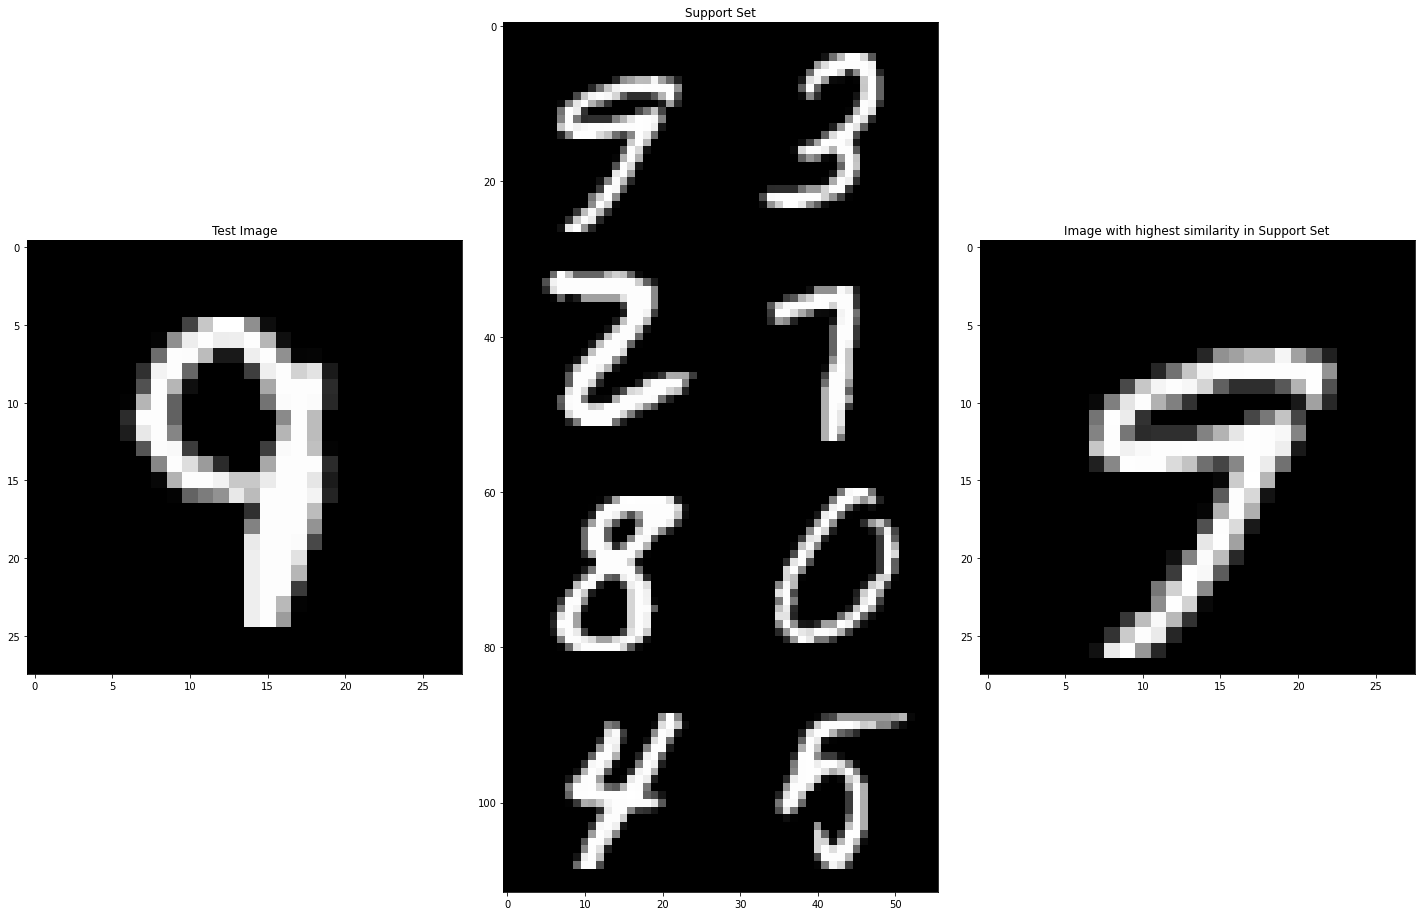

In [ ]:
n_samples = 8
img0, img_matrix, index, X_right = visualize_N_way(n_samples)

f, ax=  plt.subplots(1,3, figsize = (20,20))
f.tight_layout()
ax[0].imshow(img0, cmap = 'gray')
ax[0].set_title('Test Image')
ax[1].imshow(img_matrix, cmap = 'gray')
ax[1].set_title('Support Set')
ax[2].imshow(X_right[index], cmap = 'gray')
ax[2].set_title('Image with highest similarity in Support Set')